# Proyecto Final: Clasificación de Sentimientos

In [1]:
# Librerías principales
import pandas as pd
import numpy as np


import torch
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocesamiento de texto
import re
from collections import Counter
#Identificar palabras clave por sentimientos
from nltk.corpus import stopwords
import nltk

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuracion
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#Dividir el data set
from sklearn.model_selection import train_test_split

#Importamos las librerias para los algoritmos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import RandomOverSampler

# COLORES DE MATPLOT y tamaño de las gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

d:\Principal\Respaldo Diws 2020\Buap\Octavo Semestre\Mineria\proyecto final\codigos\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Descargar stopwords si es necesario
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) 
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diws\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diws\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Definir stopwords en español
stop_words = set(stopwords.words('spanish'))

# Inicializar lematizador y stemmer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("spanish")

<h1> Análisis Exploratorio de Datos (EDA) </h1>

In [4]:
# Cargar el dataset
dataset_path = "Textos_Dataset_Completo.csv"  # Cambia el path si es necesario
dataset = pd.read_csv(dataset_path, encoding="latin1")

In [5]:
# Mostrar información básica
print("Información del Dataset:")
print(dataset.info())

Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 20 columns):
 #   Column                                                                                                                                                                                                                      Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                      --------------  ----- 
 0   Marca temporal                                                                                                                                                                                                              288 non-null    object
 1   ID ònico                                                                                                                 

In [6]:
print("\nVista preliminar del Dataset:")
print(dataset.head())


Vista preliminar del Dataset:
       Marca temporal  ID ònico  Edad:    Gnero: Nivel socioeconmico:  \
0  4/23/2024 19:48:07  PFNKXS54     28  Masculino                 Medio   
1  4/23/2024 19:48:07  MKZUPRJI     21  Masculino                  Bajo   
2  4/23/2024 19:48:07  UJCL56SG     22  Masculino                 Medio   
3  4/23/2024 19:48:07  B2KUCT4P     20   Femenino                 Medio   
4  4/23/2024 19:48:07  GXLRPJ5F     22   Femenino                 Medio   

  Grado de estudios: Actualmente te encuentras:  \
0           Maestra                      Ambos   
1       Licenciatura                      Ambos   
2       Licenciatura                      Ambos   
3       Licenciatura                 Estudiando   
4       Licenciatura                 Estudiando   

     Si actualmente trabajas. ÀEn qu rea trabajas? Estado de origen:  \
0  Sector de la educacin - Maestros, educadores,...          Veracruz   
1  Comercio y ventas - Vendedores, gerentes de ti...          V

In [7]:
# Verificar valores nulos
print("\nValores nulos por columna:")
print(dataset.isnull().sum())


Valores nulos por columna:
Marca temporal                                                                                                                                                                                                                0
ID ònico                                                                                                                                                                                                                      1
Edad:                                                                                                                                                                                                                         0
Gnero:                                                                                                                                                                                                                       0
Nivel socioeconmico:                                                       

In [8]:
# Respuestas por pregunta
preguntas = [col for col in dataset.columns if col.startswith('1.') or col.startswith('2.') or col.startswith('3.')or col.startswith('4.')or col.startswith('5.')
             or col.startswith('6.') or col.startswith('7.') or col.startswith('8.') or col.startswith('9.') or col.startswith('10.')]
print("Cantidad de respuestas por pregunta:")
for pregunta in preguntas:
    print(f"{pregunta}: {dataset[pregunta].notnull().sum()} respuestas")

Cantidad de respuestas por pregunta:
1. Describa, Àen qu situaciones ltimamente ha sentido alegra?: 288 respuestas
2. Especifique, Àen qu situaciones ltimamente ha sentido ganas de llorar?: 288 respuestas
3. En las ltimas dos semanas, Àen qu momentos se ha sentido cansado?: 288 respuestas
4. ÀEn qu situaciones de su da a da, puede identificar que se ha sentido preocupado?: 288 respuestas
5. Cuando la preocupacin se hace presente en su vida, Àcules son las sensaciones corporales que experimenta?: 288 respuestas
6. Si su escritor favorito le pidiera que le ayude a buscar el significado de la felicidad, Àcul sera la idea que usted escribira?: 288 respuestas
7. Cuando tiene una eleccin importante que hacer, mencione Àcules seran los pasos que seguira para llegar a tomar una decisin?: 288 respuestas
8. Cuando sucede algo inesperado en su vida, por ejemplo: llegar tarde al trabajo, el automvil se descompuso, se qued sin batera el celular, olvidar las llaves, etc., desc

In [9]:
# Frecuencia de categorías de sentimiento
categorias = {
    "Alegría": ["1.", "6."],
    "Tristeza": ["2."],
    "Estrés": ["3.", "9."],
    "Inquietud/Preocupación": ["4.", "5."],
    "Miedo": ["7.", "10."],
    "Enojo": ["8."]
}

In [10]:
frecuencias = {}
for categoria, preguntas_cat in categorias.items():
    # Filtrar columnas que coincidan con los prefijos dados
    columnas = [col for col in dataset.columns if any(col.startswith(p) for p in preguntas_cat)]
    # Contar respuestas no nulas en estas columnas
    total_respuestas = dataset[columnas].notnull().sum().sum()
    frecuencias[categoria] = total_respuestas

In [11]:
print("\nFrecuencia de respuestas por categoría de sentimiento:")
print(frecuencias)


Frecuencia de respuestas por categoría de sentimiento:
{'Alegría': np.int64(576), 'Tristeza': np.int64(288), 'Estrés': np.int64(576), 'Inquietud/Preocupación': np.int64(576), 'Miedo': np.int64(576), 'Enojo': np.int64(288)}


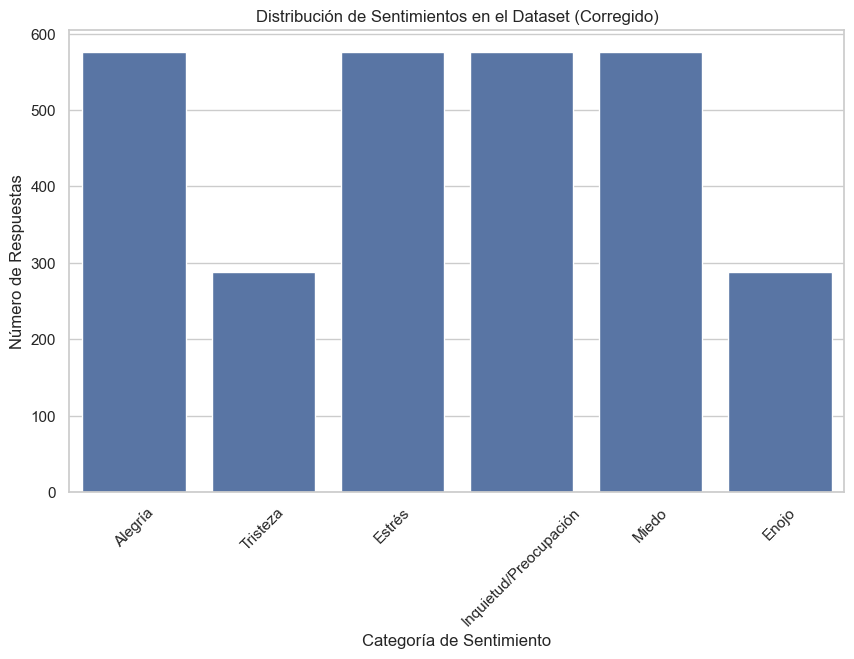

In [12]:
# Visualización de frecuencias corregidas
sns.barplot(x=list(frecuencias.keys()), y=list(frecuencias.values()))
plt.title("Distribución de Sentimientos en el Dataset (Corregido)")
plt.xlabel("Categoría de Sentimiento")
plt.ylabel("Número de Respuestas")
plt.xticks(rotation=45)
plt.show()

In [13]:
def generar_nube_palabras(data, columnas, titulo):
    # Concatenar respuestas en una sola cadena, asegurando que todo sea texto
    texto = " ".join(data[columnas].fillna("").astype(str).sum(axis=1))
    
    # Crear la nube de palabras
    nube = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto)
    
    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 6))
    plt.imshow(nube, interpolation="bilinear")
    plt.title(titulo, fontsize=16)
    plt.axis("off")
    plt.show()

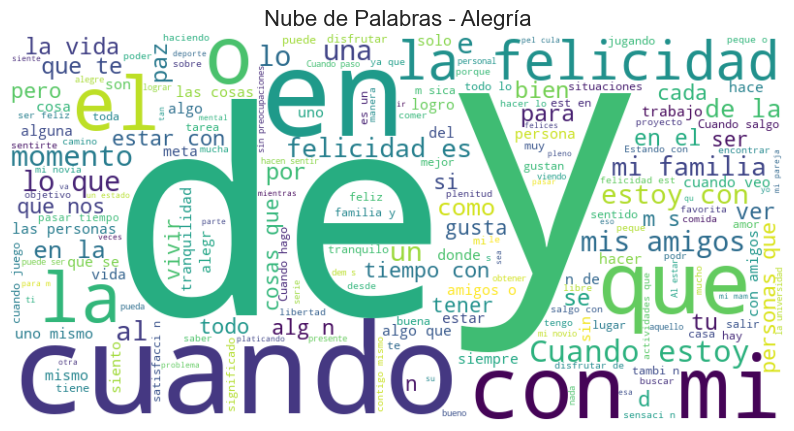

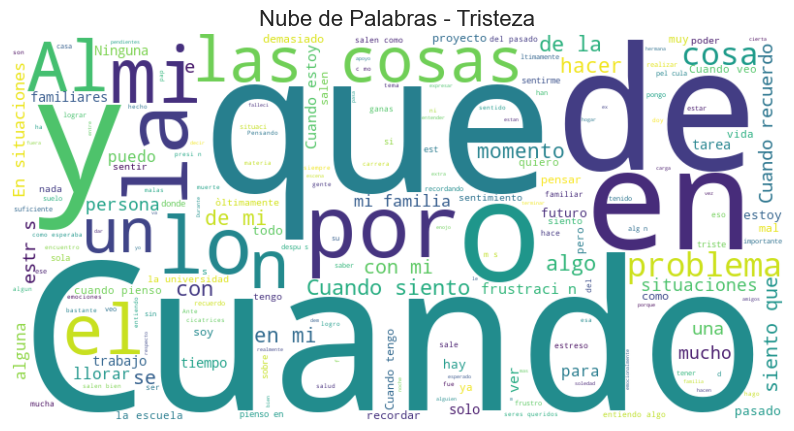

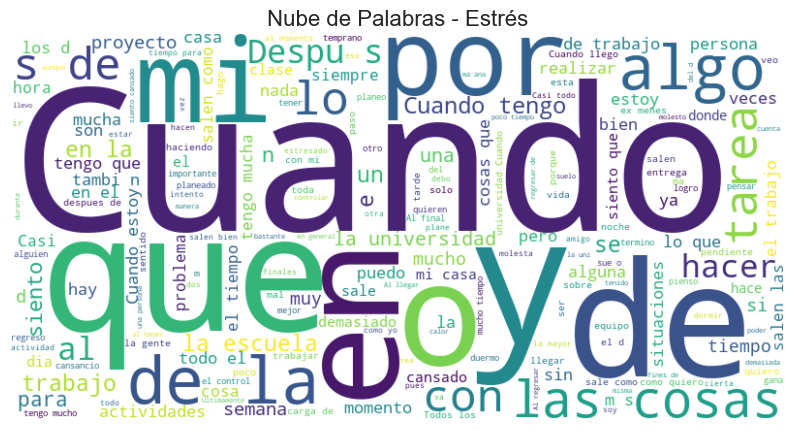

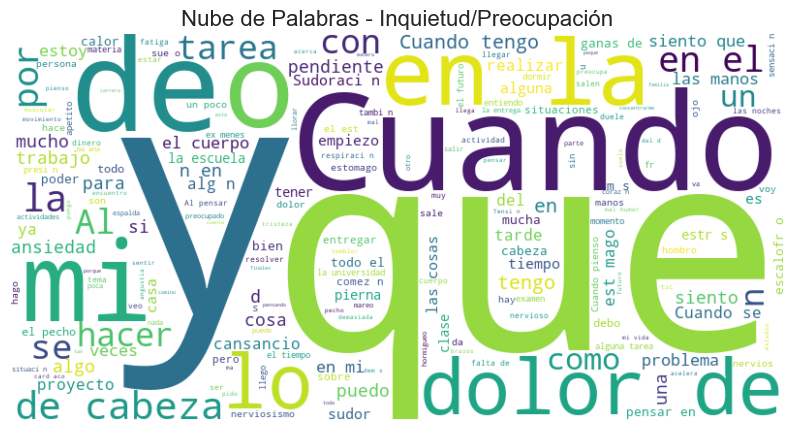

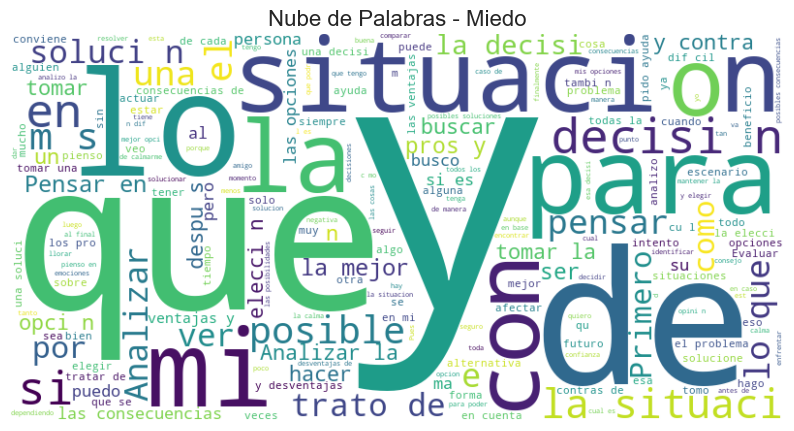

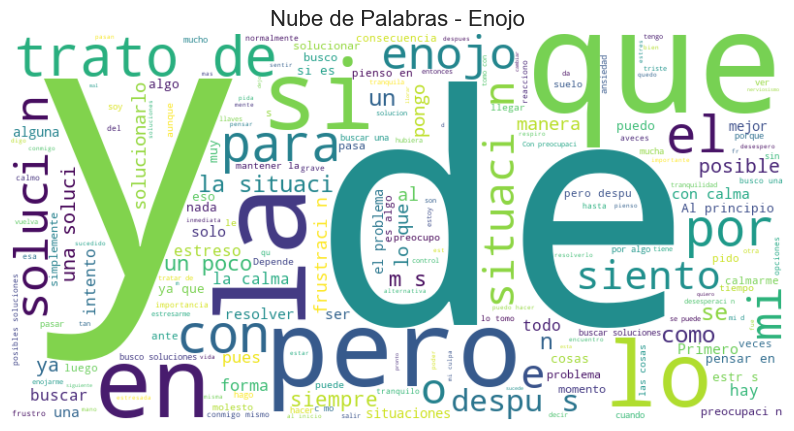

In [14]:
# Generar nube de palabras para cada sentimiento
for sentimiento, preguntas_cat in categorias.items():
    columnas = [col for col in dataset.columns if any(col.startswith(p) for p in preguntas_cat)]
    generar_nube_palabras(dataset, columnas, f"Nube de Palabras - {sentimiento}")

In [15]:
def palabras_frecuentes(data, columnas, titulo, top_n=10):
    """
    Identificar las palabras más frecuentes en un conjunto de textos.
    """
    # Concatenar todas las respuestas en una sola cadena
    texto = " ".join(data[columnas].fillna("").astype(str).sum(axis=1))
    
    # Preprocesar el texto: convertir a minúsculas y eliminar caracteres especiales
    texto_limpio = re.sub(r"[^a-zA-ZáéíóúñÑ\s]", "", texto.lower())
    
    # Tokenizar el texto
    palabras = texto_limpio.split()
    
    # Filtrar palabras vacías (stopwords)
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    
    # Contar la frecuencia de cada palabra
    conteo = Counter(palabras)
    
    # Obtener las palabras más comunes
    palabras_comunes = conteo.most_common(top_n)
    
    # Mostrar resultados
    print(f"Palabras más frecuentes para {titulo}:")
    for palabra, frecuencia in palabras_comunes:
        print(f"{palabra}: {frecuencia}")
    
    # Visualizar con una gráfica de barras
    palabras, frecuencias = zip(*palabras_comunes)
    plt.bar(palabras, frecuencias)
    plt.title(f"Palabras más frecuentes - {titulo}")
    plt.xlabel("Palabras")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.show()

Palabras más frecuentes para Alegría:
felicidad: 122
amigos: 86
familia: 54
vida: 54
cosas: 53
mismo: 47
personas: 46
tiempo: 43
bien: 42
momentos: 37


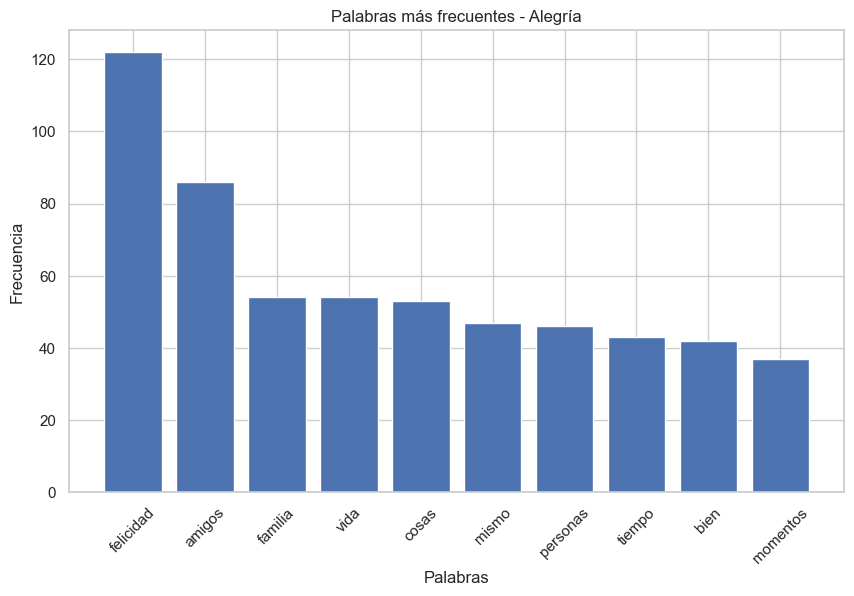

Palabras más frecuentes para Tristeza:
siento: 49
cosas: 48
situaciones: 31
hacer: 20
salen: 20
recuerdo: 20
problemas: 19
estrs: 17
familia: 17
pasado: 17


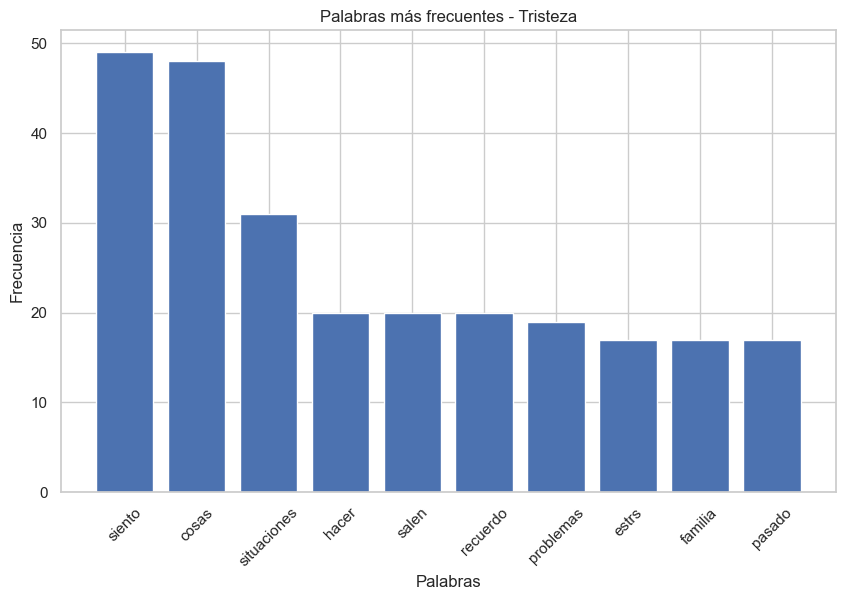

Palabras más frecuentes para Estrés:
cosas: 99
trabajo: 61
tiempo: 58
siento: 56
despus: 51
hacer: 48
salen: 47
escuela: 45
tareas: 37
casa: 34


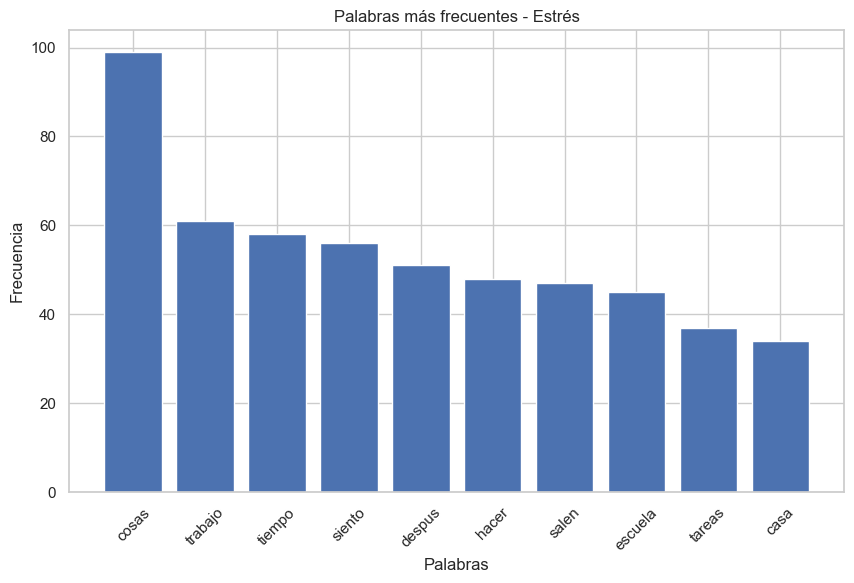

Palabras más frecuentes para Inquietud/Preocupación:
cabeza: 72
dolor: 63
siento: 41
hacer: 40
cosas: 36
tareas: 28
manos: 27
cuerpo: 26
da: 24
pensar: 24


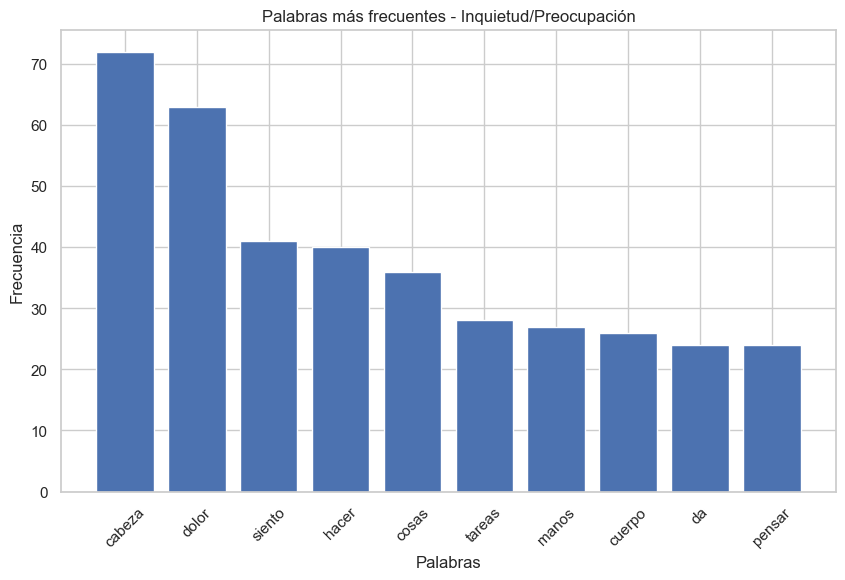

Palabras más frecuentes para Miedo:
situacin: 123
si: 118
pensar: 109
analizar: 94
decisin: 84
tomar: 84
ms: 83
mejor: 76
consecuencias: 73
posibles: 66


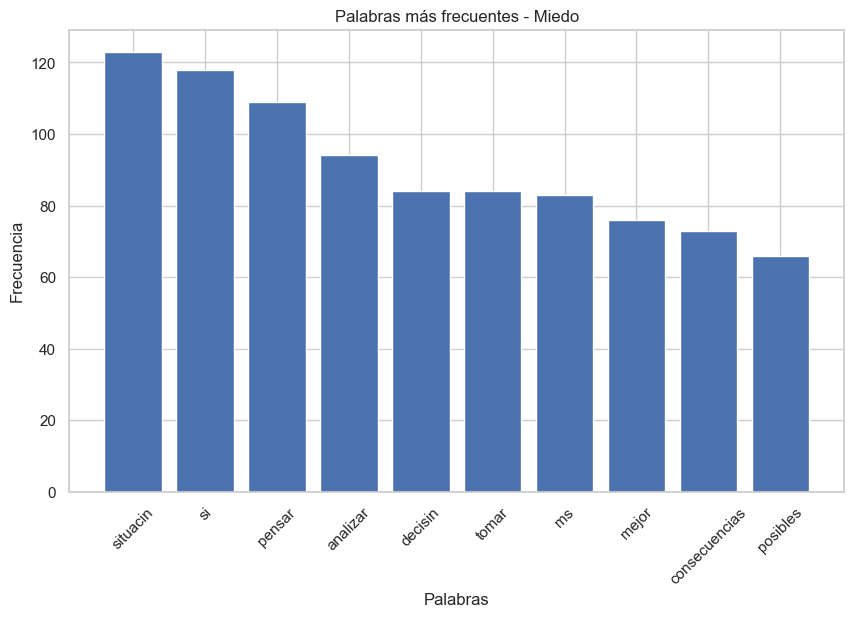

Palabras más frecuentes para Enojo:
si: 70
trato: 51
solucin: 37
enojo: 36
situacin: 32
buscar: 30
calma: 30
despus: 28
siento: 28
soluciones: 28


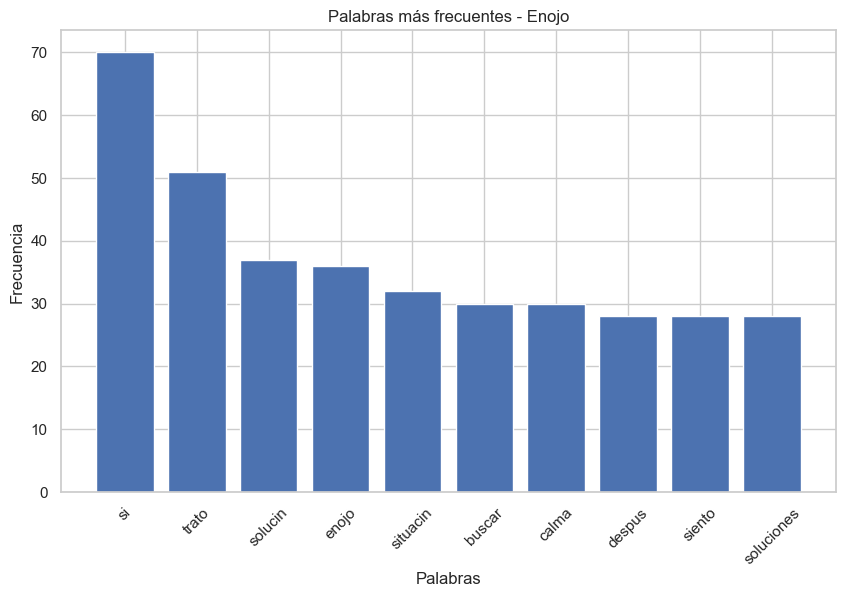

In [16]:
# Identificar palabras clave para cada sentimiento
for sentimiento, preguntas_cat in categorias.items():
    columnas = [col for col in dataset.columns if any(col.startswith(p) for p in preguntas_cat)]
    palabras_frecuentes(dataset, columnas, sentimiento, top_n=10)

<h1> Preprocesamiento de Texto </h1>

In [17]:
def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres especiales y números
    texto = re.sub(r"[^a-záéíóúñ\s]", "", texto)
    # Eliminar números
    texto = re.sub(r"\d+", "", texto)
    return texto

In [18]:
def procesar_texto(texto, lematizar=True):
    # Limpieza básica
    texto_limpio = limpiar_texto(texto)
    # Tokenización
    palabras = texto_limpio.split()
    # Eliminar stopwords
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    # Lematización o Stemming
    if lematizar:
        palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras]
    else:
        palabras = [stemmer.stem(palabra) for palabra in palabras]
    return " ".join(palabras)

# Aplicar a todas las columnas relacionadas con las preguntas
for col in dataset.columns:
    if col.startswith(tuple(str(i) for i in range(1, 11))):  # Filtrar preguntas
        dataset[col] = dataset[col].fillna("").apply(procesar_texto)

In [19]:
# Crear una nueva columna de etiquetas de sentimiento utilizando el diccionario 'categorias'
def etiquetar_sentimiento(row):
    etiquetas = []
    for sentimiento, preguntas in categorias.items():
        # Verificar si alguna columna asociada al sentimiento tiene datos
        if any(row[col] for col in dataset.columns if any(col.startswith(p) for p in preguntas)):
            etiquetas.append(sentimiento)
    return ", ".join(etiquetas) if etiquetas else "Sin Etiqueta"

# Aplicar la función para etiquetar
dataset['Sentimiento'] = dataset.apply(etiquetar_sentimiento, axis=1)

# Verificar la distribución de las etiquetas
print("Distribución de sentimientos:")
print(dataset['Sentimiento'].value_counts())

Distribución de sentimientos:
Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    288
Name: count, dtype: int64


In [20]:
# Combinar todas las columnas relacionadas con las preguntas
dataset['Texto_Procesado'] = dataset[
    [col for col in dataset.columns if col.startswith(tuple(str(i) for i in range(1, 11)))]
].apply(lambda x: " ".join(x), axis=1)

# Vectorizar el texto procesado usando TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Puedes ajustar el número máximo de características
tfidf_matrix = vectorizer.fit_transform(dataset['Texto_Procesado'])

# Convertir a DataFrame para inspección
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_df.head())

   accin  acciones  acerca  actividad  actividades  actuar   acuerdo  adems  \
0    0.0       0.0     0.0        0.0     0.143126     0.0  0.000000    0.0   
1    0.0       0.0     0.0        0.0     0.185945     0.0  0.000000    0.0   
2    0.0       0.0     0.0        0.0     0.000000     0.0  0.000000    0.0   
3    0.0       0.0     0.0        0.0     0.000000     0.0  0.000000    0.0   
4    0.0       0.0     0.0        0.0     0.000000     0.0  0.156682    0.0   

   afecta  afectan  ...       ver  verdad  vez  vida  videojuegos  viendo  \
0     0.0      0.0  ...  0.000000     0.0  0.0   0.0          0.0     0.0   
1     0.0      0.0  ...  0.000000     0.0  0.0   0.0          0.0     0.0   
2     0.0      0.0  ...  0.219137     0.0  0.0   0.0          0.0     0.0   
3     0.0      0.0  ...  0.000000     0.0  0.0   0.0          0.0     0.0   
4     0.0      0.0  ...  0.074808     0.0  0.0   0.0          0.0     0.0   

   vista  visualizar  vivir  voy  
0    0.0         0.0    0.0

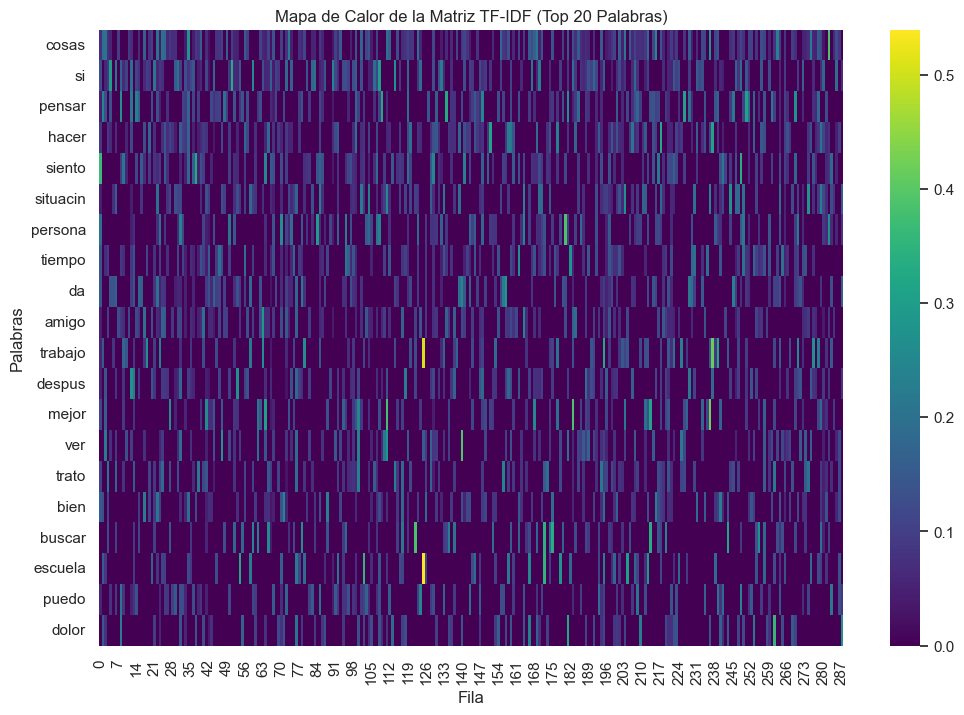

In [21]:
# Seleccionar las 20 palabras más frecuentes (mayores valores TF-IDF promedio)
top_words = tfidf_df.mean().sort_values(ascending=False).head(20).index

# Filtrar la matriz TF-IDF para estas palabras
tfidf_top = tfidf_df[top_words]

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_top.T, cmap="viridis", annot=False, cbar=True, yticklabels=top_words)
plt.title("Mapa de Calor de la Matriz TF-IDF (Top 20 Palabras)")
plt.xlabel("Fila")
plt.ylabel("Palabras")
plt.show()

<h1> Generacion de Embeddings usando Transformers </h1>

In [22]:
# Seleccionar un modelo preentrenado de Hugging Face (puedes cambiar a otro modelo)
MODEL_NAME = "distilbert-base-uncased"  # Puedes usar "bert-base-uncased" u otros modelos

# Cargar el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Asegurar que el modelo está en modo de evaluación
model.eval()

# Función para generar embeddings
def generar_embeddings(textos):
    """
    Generar embeddings para una lista de textos utilizando un modelo de transformer.
    """
    embeddings = []
    with torch.no_grad():  # No calculamos gradientes para ahorrar memoria
        for texto in textos:
            # Tokenizar el texto
            inputs = tokenizer(texto, return_tensors="pt", padding=True, truncation=True, max_length=512)
            # Pasar el texto por el modelo para obtener las representaciones
            outputs = model(**inputs)
            # Extraer la representación de la última capa (CLS token)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

# Aplicar la función a los textos procesados
textos = dataset['Texto_Procesado'].fillna("").tolist()  # Convertir la columna de texto procesado a una lista
embeddings = generar_embeddings(textos)

# Convertir los embeddings a un DataFrame para inspección (opcional)
embeddings_df = pd.DataFrame(embeddings)
print(embeddings_df.head())

# Guardar los embeddings en el dataset
dataset["Embeddings"] = list(embeddings)

# Guardar los embeddings en un archivo para usarlos en modelos
np.save("embeddings.npy", embeddings)  # Guardar como matriz numpy

        0         1         2         3         4         5         6    \
0 -0.483836 -0.226051  0.035672 -0.055744 -0.117339 -0.041274  0.218737   
1 -0.233931  0.028398 -0.019785 -0.027157 -0.097061 -0.094168  0.081662   
2 -0.409237 -0.232731  0.007487 -0.136494 -0.140674  0.004785  0.177626   
3 -0.336191 -0.176305  0.064195  0.012310 -0.109222  0.062274  0.259470   
4 -0.323873 -0.199163  0.084853 -0.083491 -0.148371 -0.049533  0.246356   

        7         8         9    ...       758       759       760       761  \
0  0.116238 -0.143358 -0.075397  ...  0.415161 -0.474093  0.037099 -0.110248   
1  0.315180  0.005865 -0.071273  ...  0.553324 -0.419483  0.013343 -0.306667   
2  0.140882 -0.190175 -0.212305  ...  0.524099 -0.463503  0.073576 -0.120200   
3  0.262761 -0.047666 -0.128688  ...  0.596663 -0.618699  0.153130 -0.277713   
4  0.254091  0.014559 -0.132007  ...  0.649280 -0.587316  0.052379 -0.150627   

        762       763       764       765       766       767  
0  0

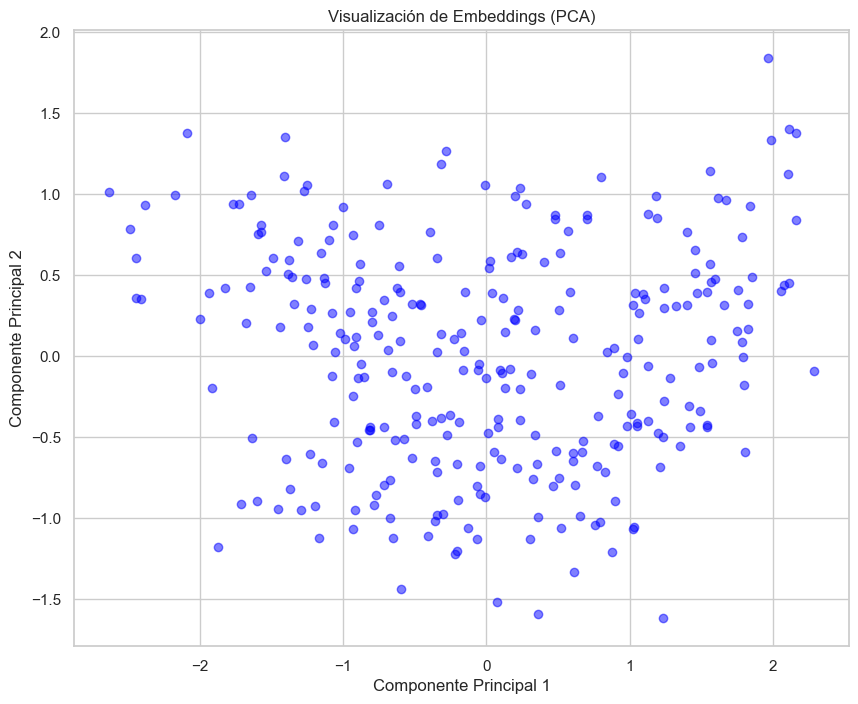

In [23]:
# Reducir la dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Visualizar los embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c='blue', alpha=0.5)
plt.title("Visualización de Embeddings (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

<h1> Division de DataSet </h1>

In [24]:
# Seleccionar características (X) y etiquetas (y)
X = embeddings  # Usaremos los embeddings generados como características
y = dataset['Sentimiento']  # Las etiquetas de sentimiento

# División del dataset (80% entrenamiento, 20% prueba) manteniendo la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la distribución de clases en los conjuntos
print("Distribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución de clases en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))

Distribución de clases en el conjunto de entrenamiento:
Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    1.0
Name: proportion, dtype: float64

Distribución de clases en el conjunto de prueba:
Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    1.0
Name: proportion, dtype: float64


In [25]:
#Probar Diferentes Proporciones
#Si queremos comparar el impacto de diferentes configuraciones en el rendimiento del modelo,
# podemos probar diferentes proporciones de división de datos.
for test_size in [0.1, 0.2, 0.3]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    print(f"Proporción de prueba: {test_size}")
    print("Entrenamiento:", y_train.value_counts(normalize=True))
    print("Prueba:", y_test.value_counts(normalize=True))
    print("-" * 50)

Proporción de prueba: 0.1
Entrenamiento: Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    1.0
Name: proportion, dtype: float64
Prueba: Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    1.0
Name: proportion, dtype: float64
--------------------------------------------------
Proporción de prueba: 0.2
Entrenamiento: Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    1.0
Name: proportion, dtype: float64
Prueba: Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    1.0
Name: proportion, dtype: float64
--------------------------------------------------
Proporción de prueba: 0.3
Entrenamiento: Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    1.0
Name: proportion, dtype: float64
Prueba: Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    1.0
Name: proportion, dtype: float64
--------------------------------------------------


<h1>Implementación de Algoritmos de Clasificación en Python</h1>

In [26]:
# Probar diferentes valores de k para KNN
for k in [3, 5, 7]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predicciones en el conjunto de prueba
    y_pred_knn = knn.predict(X_test)
    
    # Evaluar el rendimiento
    print(f"\n--- Resultados para KNN con k={k} ---")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred_knn))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred_knn))
    print(f"Precisión: {accuracy_score(y_test, y_pred_knn):.2f}")


--- Resultados para KNN con k=3 ---
Matriz de Confusión:
[[87]]

Reporte de Clasificación:
                                                                 precision    recall  f1-score   support

Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo       1.00      1.00      1.00        87

                                                       accuracy                           1.00        87
                                                      macro avg       1.00      1.00      1.00        87
                                                   weighted avg       1.00      1.00      1.00        87

Precisión: 1.00

--- Resultados para KNN con k=5 ---
Matriz de Confusión:
[[87]]

Reporte de Clasificación:
                                                                 precision    recall  f1-score   support

Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo       1.00      1.00      1.00        87

                                                       accur

d:\Principal\Respaldo Diws 2020\Buap\Octavo Semestre\Mineria\proyecto final\codigos\env\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\Principal\Respaldo Diws 2020\Buap\Octavo Semestre\Mineria\proyecto final\codigos\env\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\Principal\Respaldo Diws 2020\Buap\Octavo Semestre\Mineria\proyecto final\codigos\env\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [27]:
# Verificar la distribución de clases
print("Distribución de clases en el conjunto completo:")
print(y.value_counts())

print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())

print("\nDistribución de clases en el conjunto de prueba:")
print(y_test.value_counts())

Distribución de clases en el conjunto completo:
Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    288
Name: count, dtype: int64

Distribución de clases en el conjunto de entrenamiento:
Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    201
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    87
Name: count, dtype: int64


In [29]:
# Realizar una nueva división estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verificar nuevamente la distribución
print("Distribución de clases después de la nueva división:")
print(y_train.value_counts())

Distribución de clases después de la nueva división:
Sentimiento
Alegría, Tristeza, Estrés, Inquietud/Preocupación, Miedo, Enojo    230
Name: count, dtype: int64


In [31]:
# Aplicar sobremuestreo
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Verificar la distribución después del sobremuestreo
print("Distribución de clases después del sobremuestreo:")
print(pd.Series(y_train_resampled).value_counts())

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [ ]:
# Probar SVM con kernel lineal
svm_linear = SVC(kernel="linear", C=1, random_state=42)
svm_linear.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_svm_linear = svm_linear.predict(X_test)

# Evaluar el rendimiento
print("\n--- Resultados para SVM (Kernel Lineal) ---")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_svm_linear))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm_linear))
print(f"Precisión: {accuracy_score(y_test, y_pred_svm_linear):.2f}")

# Probar SVM con kernel RBF
svm_rbf = SVC(kernel="rbf", C=1, gamma=0.1, random_state=42)
svm_rbf.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_svm_rbf = svm_rbf.predict(X_test)

# Evaluar el rendimiento
print("\n--- Resultados para SVM (Kernel RBF) ---")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_svm_rbf))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm_rbf))
print(f"Precisión: {accuracy_score(y_test, y_pred_svm_rbf):.2f}")

In [ ]:
# Crear un DataFrame con los resultados de los modelos
resultados = {
    "Modelo": ["KNN (k=3)", "KNN (k=5)", "KNN (k=7)", "SVM (Linear)", "SVM (RBF)"],
    "Precisión": [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_svm_linear),
        accuracy_score(y_test, y_pred_svm_rbf),
    ]
}

resultados_df = pd.DataFrame(resultados)
print(resultados_df)

# Visualizar las métricas con un gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(resultados_df["Modelo"], resultados_df["Precisión"], color="skyblue")
plt.title("Comparación de Precisión entre Modelos")
plt.ylabel("Precisión")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.show()